In [ ]:
pip install scikit-learn


In [ ]:
pip install pandas 


In [ ]:
pip install pandas openpyxl


In [83]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
pip install matplotlib


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 3.3 MB/s eta 0:00:03
   --- ------------------------------------ 0.8/8.1 MB 2.9 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/8.1 MB 2.1 MB/s eta 0:00:04
   ---------- ----------------------------- 2.1/8.1 MB 2.4 MB/s eta 0:00:03
   ------------- -------------------------- 2.6/8.1 MB 2.4 MB/s eta 0:00:03
   --------------- ------------------------ 3.1/8.1 MB 2.4 MB/s eta 0:00:03
   ------------------ --------------------- 3.7/8.1 MB 2.5 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.1 MB 2.5 MB/s eta 0:00:02
   ------------------------ --------------- 5.0/8.1 MB 2.5 MB/s eta 0:00:02
   --------------------------- ------------ 5.5/8.1 MB 2.5 MB/s eta 0:00:02
   ------------------------------- -------- 6.3/8.1 MB 2.5 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 2.5 MB/s eta 0:00:01
   ----------------


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


CELL 1 

In [61]:
import pandas as pd
import os

# Folder where datasets are located
data_dir = "C:/Users/SLS/Desktop/Electric/data"

# List of EIA930 BALANCE demand files
balance_files = [
    "EIA930_BALANCE_2018_Jul_Dec.csv",
    "EIA930_BALANCE_2019_Jan_Jun.csv",
    "EIA930_BALANCE_2019_Jul_Dec.csv",
    "EIA930_BALANCE_2020_Jan_Jun.csv"
]

# Columns we need from each BALANCE file
columns_needed = [
    "Balancing Authority",
    "Data Date",
    "Hour Number",
    "Demand (MW)"
]

# Read and combine all balance files
balance_data = []

for file in balance_files:
    path = os.path.join(data_dir, file)
    df = pd.read_csv(path, usecols=columns_needed, dtype=str)  # Read all as strings to avoid dtype warnings
    
    # Drop rows with missing demand
    df = df.dropna(subset=["Demand (MW)", "Data Date", "Hour Number", "Balancing Authority"])
    
    # Clean numeric demand values: remove commas and convert to float
    df["Electricity_Demand_MWh"] = df["Demand (MW)"].str.replace(",", "").astype(float)
    
    # Convert Data Date and Hour Number to Timestamp
    df["Timestamp"] = pd.to_datetime(df["Data Date"]) + pd.to_timedelta(df["Hour Number"].astype(int) - 1, unit='h')
    
    # Keep necessary columns
    df = df[["Timestamp", "Electricity_Demand_MWh", "Balancing Authority"]]
    
    balance_data.append(df)

# Combine all into one dataframe
final_balance_df = pd.concat(balance_data, ignore_index=True)

# Optional: sort by timestamp
final_balance_df = final_balance_df.sort_values("Timestamp").reset_index(drop=True)

# Preview the cleaned data
print(final_balance_df.head())

# Save cleaned dataset
final_path = "C:/Users/SLS/Desktop/Electric/cleaned_balance_combined.csv"
final_balance_df.to_csv(final_path, index=False)

print(f"✅ Cleaned balance dataset saved to: {final_path}")


   Timestamp  Electricity_Demand_MWh Balancing Authority
0 2018-07-01                   286.0                 TAL
1 2018-07-01                  4237.0                PSCO
2 2018-07-01                   912.0                 AVA
3 2018-07-01                  2282.0                IPCO
4 2018-07-01                 81462.0                MISO
✅ Cleaned balance dataset saved to: C:/Users/SLS/Desktop/Electric/cleaned_balance_combined.csv


CELL 2

In [70]:
import pandas as pd
import json
import os
from datetime import datetime

# Define directories
data_dir = "C:/Users/SLS/Desktop/Electric"
city_dir = os.path.join(data_dir, "data")

# Load cleaned electricity demand dataset
demand_df = pd.read_csv(os.path.join(data_dir, "cleaned_balance_combined.csv"))
demand_df['Timestamp'] = pd.to_datetime(demand_df['Timestamp'])

# City list (same as used in mapping)
cities = [
    "la", "nyc", "houston", "philadelphia", "phoenix",
    "san_antonio", "san_diego", "san_jose", "seattle", "dallas"
]

# List to collect city weather dataframes
weather_dfs = []

for city in cities:
    json_file_path = os.path.join(city_dir, f"{city}.json")

    # Read the raw file as a string and format it to valid JSON array
    with open(json_file_path, "r") as f:
        raw_data = f.read()

    # Fix malformed JSON if necessary
    if not raw_data.strip().startswith("["):
        raw_data = "[" + raw_data.strip().rstrip(",") + "]"

    # Parse JSON
    try:
        weather_data = json.loads(raw_data)
    except json.JSONDecodeError as e:
        raise ValueError(f"Error decoding JSON in {city}.json: {e}")

    # Convert to DataFrame
    df = pd.json_normalize(weather_data)

    # Convert UNIX time to Timestamp
    df['Timestamp'] = pd.to_datetime(df['time'], unit='s')

    # ⚠️ Fix: Add city column in lowercase with spaces (match demand_df format)
    df['City'] = city.replace("_", " ").lower()

    # Select relevant columns
    selected_columns = ['Timestamp', 'City', 'temperature', 'humidity', 'windSpeed']
    optional_columns = ['pressure', 'precipIntensity', 'precipProbability']

    for col in optional_columns:
        if col in df.columns:
            selected_columns.append(col)

    weather_dfs.append(df[selected_columns])

# Combine all weather DataFrames
weather_df = pd.concat(weather_dfs, ignore_index=True)

# Save the merged weather dataset
output_path = os.path.join(data_dir, "final_weather_demand_merged.csv")
weather_df.to_csv(output_path, index=False)

print("✅ Final weather dataset saved to:", output_path)


✅ Final weather dataset saved to: C:/Users/SLS/Desktop/Electric\final_weather_demand_merged.csv


In [76]:
import pandas as pd

demand_df = pd.read_csv("C:/Users/SLS/Desktop/Electric/cleaned_balance_combined.csv")

# Check unique Balancing Authorities
print("Unique Balancing Authorities:")
print(demand_df['Balancing Authority'].dropna().unique())

# Count rows per Balancing Authority
print("\nRow count per Balancing Authority:")
print(demand_df['Balancing Authority'].value_counts())


Unique Balancing Authorities:
['TAL' 'PSCO' 'AVA' 'IPCO' 'MISO' 'IID' 'PNM' 'AZPS' 'CPLE' 'TIDC' 'FMPP'
 'PGE' 'NEVP' 'FPL' 'NYIS' 'JEA' 'BPAT' 'GVL' 'DUK' 'SPA' 'CHPD' 'SEC'
 'SOCO' 'EPE' 'GCPD' 'TEC' 'PACE' 'SC' 'PSEI' 'PACW' 'CPLW' 'NWMT' 'DOPD'
 'HST' 'CISO' 'PJM' 'FPC' 'WACM' 'WALC' 'ISNE' 'LGEE' 'SCEG' 'TPWR' 'SCL'
 'OVEC' 'AECI' 'WAUW' 'AEC' 'ERCO' 'LDWP' 'BANC' 'TEPC' 'TVA' 'NSB' 'SRP'
 'SWPP']

Row count per Balancing Authority:
Balancing Authority
TAL     15936
PSCO    15936
AZPS    15936
SPA     15936
BPAT    15936
ISNE    15936
PSEI    15936
GCPD    15936
EPE     15933
AECI    15931
FPL     15930
MISO    15929
NEVP    15918
DUK     15913
FPC     15913
NYIS    15912
PJM     15912
TEC     15912
WALC    15912
AVA     15912
SCEG    15912
WAUW    15910
SCL     15908
PACW    15888
PACE    15864
ERCO    15864
TIDC    15864
NWMT    15863
IPCO    15861
HST     15858
CISO    15854
CHPD    15846
CPLE    15841
CPLW    15841
WACM    15840
FMPP    15817
LGEE    15792
TPWR    15792
IID   

CELL 3

In [ ]:
import pandas as pd

# Load both final datasets
demand_path = "C:/Users/SLS/Desktop/Electric/cleaned_balance_combined.csv"
weather_path = "C:/Users/SLS/Desktop/Electric/final_weather_demand_merged.csv"

# Convert and align timestamps to the hour
demand_df['Timestamp'] = pd.to_datetime(demand_df['Timestamp']).dt.floor('h')
weather_df['Timestamp'] = pd.to_datetime(weather_df['Timestamp']).dt.floor('h')

# Map Balancing Authorities to cities
ba_city_map = {
    "CISO": "la",             # California ISO
    "NYIS": "nyc",            # New York ISO
    "ERCOT": "houston",       # Texas ERCOT (example)
    "PJM": "philadelphia",    # PJM Interconnection
    "ISNE": "boston",         # ISO New England
    "SWPP": "dallas",         # Southwest Power Pool
    "SOCO": "atlanta",        # Southern Company
    "TVA": "nashville",       # Tennessee Valley Authority
    "MISO": "chicago",        # Midcontinent ISO
    "BANC": "sacramento",     # Balancing Authority of Northern California
    "SRP": "phoenix",         # Salt River Project
    "LDWP": "los angeles",    # LA Department of Water and Power
    "TEPC": "tucson",         # Tucson Electric Power
    "PSCO": "denver",         # Public Service Company of Colorado
    "PNM": "albuquerque",     # Public Service Co. of New Mexico
    "PACE": "salt lake city", # PacifiCorp East
    "PACW": "portland",       # PacifiCorp West
    "PSEI": "seattle",        # Puget Sound Energy
    "FPL": "miami",           # Florida Power & Light
    # Add more mappings if needed
}

# Apply city mapping to demand data
demand_df['City'] = demand_df['Balancing Authority'].map(ba_city_map)

# Drop rows with missing city mapping (unmapped balancing authorities)
demand_df = demand_df.dropna(subset=['City'])

# Ensure only cities present in both datasets are used
common_cities = set(demand_df['City']).intersection(set(weather_df['City']))
demand_df = demand_df[demand_df['City'].isin(common_cities)]
weather_df = weather_df[weather_df['City'].isin(common_cities)]

# Merge demand and weather data on Timestamp and City
merged_df = pd.merge(demand_df, weather_df, on=['Timestamp', 'City'], how='inner')

# Optional: Print row counts to verify
print("Cities in demand data:", demand_df['City'].unique())
print("Cities in weather data:", weather_df['City'].unique())
print("Rows per city after merge:\n", merged_df['City'].value_counts())

# Save the merged dataset
output_path = "C:/Users/SLS/Desktop/Electric/final_merged_weather_demand_dataset.csv"
merged_df.to_csv(output_path, index=False)
print(f"✅ Final fully merged dataset saved to: {output_path}")


Cities in demand data: ['nyc' 'seattle' 'la' 'philadelphia' 'phoenix' 'dallas']
Cities in weather data: ['la' 'nyc' 'philadelphia' 'phoenix' 'seattle' 'dallas']
Rows per city after merge:
 City
seattle         15919
nyc             15874
philadelphia    15874
la              15837
phoenix         15260
dallas          14445
Name: count, dtype: int64
✅ Final fully merged dataset saved to: C:/Users/SLS/Desktop/Electric/final_merged_weather_demand_dataset.csv


✅ Number of records per city:

City
seattle         15919
nyc             15874
philadelphia    15874
la              15837
phoenix         15260
dallas          14445
Name: count, dtype: int64


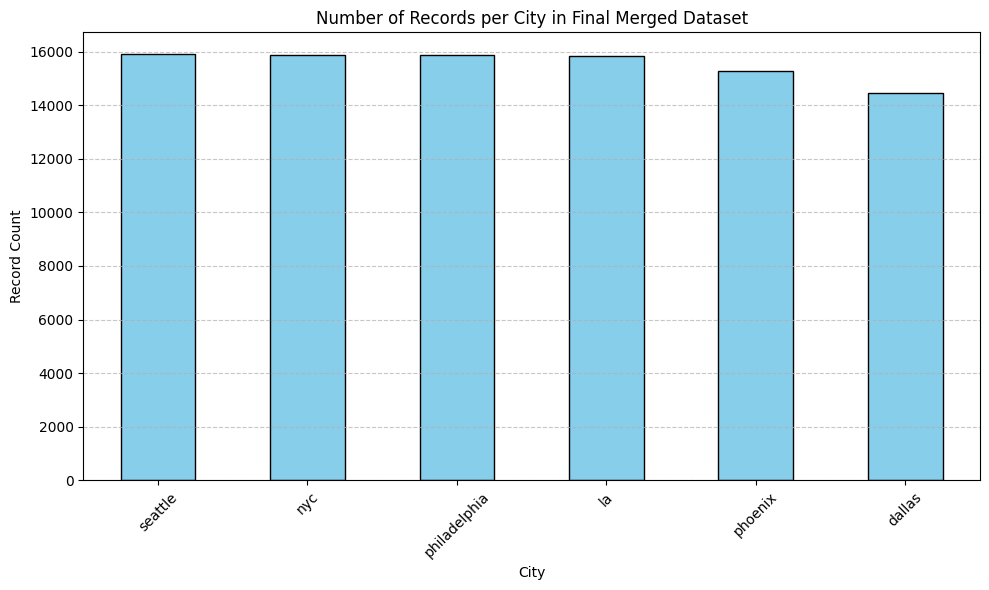

In [79]:
import pandas as pd

# Load the final merged dataset
final_df = pd.read_csv("C:/Users/SLS/Desktop/Electric/final_merged_weather_demand_dataset.csv")

# Convert Timestamp to datetime (optional if needed)
final_df['Timestamp'] = pd.to_datetime(final_df['Timestamp'])

# Show number of records per city
city_counts = final_df['City'].value_counts()
print("✅ Number of records per city:\n")
print(city_counts)

# Optional: Plot record count per city
import matplotlib.pyplot as plt

city_counts.plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Number of Records per City in Final Merged Dataset')
plt.xlabel('City')
plt.ylabel('Record Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


AGGREGATION